In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import sys
sys.path.append("/mnt/datadisk/lizhongzhan/SpaMultiOmics/main")
import anndata as ad
import networkx as nx
import scanpy as sc
from switch import SWITCH, preprocess
from itertools import chain

In [2]:
import os
os.chdir("../../../DATA/Mouse_embryo/")
# rna = sc.read_h5ad("rna.h5ad")
# atac = sc.read_h5ad("peakMat.h5ad")

In [3]:
# preprocess.get_gene_annotation(rna, 
#                     gtf="../../DATA/Mouse_embryo/gencode.vM25.annotation.gtf.gz",
#                     gtf_by="gene_name",
#                     drop_na=True
# )

In [4]:
# rna.layers["counts"] = rna.X.copy()
# sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3", layer="counts")

In [5]:
# split = atac.var_names.str.split(r"[:-]")
# atac.var["chrom"] = split.map(lambda x: x[0])
# atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
# atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
# # print(i.var)

In [6]:
# guidance = preprocess.rna_anchored_guidance_graph(rna, atac)
# guidance

In [7]:
# rna.write("rna-pp.h5ad", compression="gzip")
# atac.write("atac-pp.h5ad", compression="gzip")
# nx.write_graphml(guidance, "guidance.graphml.gz")

In [8]:
rna = ad.read_h5ad("rna-pp.h5ad")
atac = ad.read_h5ad("atac-pp.h5ad")
guidance = nx.read_graphml("guidance.graphml.gz")

In [9]:
sc.pp.filter_genes(atac, min_cells=atac.shape[0]*0.01)
len(atac.var[atac.var["highly_variable"]==True])

16134

In [10]:
preprocess.config_data(
    rna, "NB",
    use_highly_variable=True,
    use_spatial=True,
    use_layer="counts",
)
preprocess.config_data(
    atac, "NB",
    use_highly_variable=True, 
    use_spatial=True,
)

In [11]:
guidance_hvf = guidance.subgraph(chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
)).copy()

In [12]:
preprocess.Cal_Spatial_Net(rna, rad_cutoff=1, model="Radius")
preprocess.Cal_Spatial_Net(atac, rad_cutoff=1, model="Radius")

- INFO - Calculating 'spatial' graph.
The graph contains 8350 edges, 2187 spots.
3.8180 neighbors per spot on average.
- INFO - Calculating 'spatial' graph.
The graph contains 8350 edges, 2187 spots.
3.8180 neighbors per spot on average.


In [13]:
model = SWITCH(adatas={"rna": rna, "atac": atac}, vertices=sorted(guidance_hvf.nodes), dropout=0.25)

- INFO - Set random seed to 0
- DEBUG - Use raw feature for the 'rna' dataset.
- DEBUG - Set 1 GAT conv layer for 'rna' dataset.
- DEBUG - Use NB distribution for the 'rna' dataset.
- DEBUG - Use raw feature for the 'atac' dataset.
- DEBUG - Set 1 GAT conv layer for 'atac' dataset.
- DEBUG - Use NB distribution for the 'atac' dataset.
- DEBUG - Set 1 layers for the discriminator
- DEBUG - Use log normalize for the 'rna' dataset.
- DEBUG - Use log normalize for the 'atac' dataset.
- INFO - GPU available: True, used device: GPU 1


In [14]:
model.compile(lam_graph=0.4, lam_align=0.2, TTUR=0.25)

In [15]:
model.pretrain(adatas={"rna": rna, "atac": atac}, graph=guidance_hvf, max_epochs=3000, dsc_k=4)

- INFO - Prepare data for training.
- DEBUG - Set `dsc_k` = 4 for pretrain.
- DEBUG - Set `max_epochs` = 3000 for pretrain.
- INFO - Pretraining with full batch.
- INFO - Epoch 1 : dsc_loss=0.728, gen_loss=0.676
- INFO - Epoch 2 : dsc_loss=0.692, gen_loss=0.522
- INFO - Epoch 3 : dsc_loss=0.685, gen_loss=0.471
- INFO - Epoch 4 : dsc_loss=0.696, gen_loss=0.45
- INFO - Epoch 5 : dsc_loss=0.69, gen_loss=0.437
- INFO - Epoch 6 : dsc_loss=0.685, gen_loss=0.428
- INFO - Epoch 7 : dsc_loss=0.699, gen_loss=0.424
- INFO - Epoch 8 : dsc_loss=0.681, gen_loss=0.416
- INFO - Epoch 9 : dsc_loss=0.691, gen_loss=0.411
- INFO - Epoch 10 : dsc_loss=0.681, gen_loss=0.404
- INFO - Epoch 11 : dsc_loss=0.684, gen_loss=0.397
- INFO - Epoch 12 : dsc_loss=0.692, gen_loss=0.392
- INFO - Epoch 13 : dsc_loss=0.686, gen_loss=0.387
- INFO - Epoch 14 : dsc_loss=0.686, gen_loss=0.383
- INFO - Epoch 15 : dsc_loss=0.69, gen_loss=0.378
- INFO - Epoch 16 : dsc_loss=0.69, gen_loss=0.376
- INFO - Epoch 17 : dsc_loss=0.691,

In [16]:
model.train(adatas={"rna": rna, "atac": atac}, graph=guidance_hvf, max_epochs=500, dsc_k=12)

- DEBUG - Set `dsc_k` = 12 for training.
- DEBUG - Set `max_epochs` = 500 for training.
- INFO - Training with full batch.
- INFO - Epoch 1 : dsc_loss=0.688, gen_loss=0.873, cycle_loss=0.358, align_loss=0.779
- INFO - Epoch 2 : dsc_loss=0.692, gen_loss=0.869, cycle_loss=0.357, align_loss=0.771
- INFO - Epoch 3 : dsc_loss=0.688, gen_loss=0.867, cycle_loss=0.356, align_loss=0.767
- INFO - Epoch 4 : dsc_loss=0.691, gen_loss=0.864, cycle_loss=0.355, align_loss=0.765
- INFO - Epoch 5 : dsc_loss=0.69, gen_loss=0.863, cycle_loss=0.354, align_loss=0.765
- INFO - Model training done.


In [17]:
rna.obsm["SWITCH"] = model.encode_data("rna",rna)
atac.obsm["SWITCH"] = model.encode_data("atac",atac)

In [18]:
combined = ad.concat([rna, atac], label="omics")

In [66]:
sc.pp.neighbors(combined, use_rep="SWITCH", n_neighbors=30, metric="cosine")
sc.tl.umap(combined)

In [67]:
sc.tl.leiden(adata=combined, resolution=.7, key_added="leiden")
print(len(set(combined.obs["leiden"])))

15


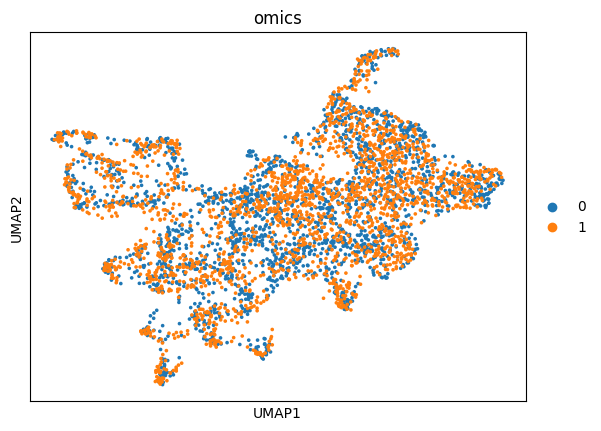

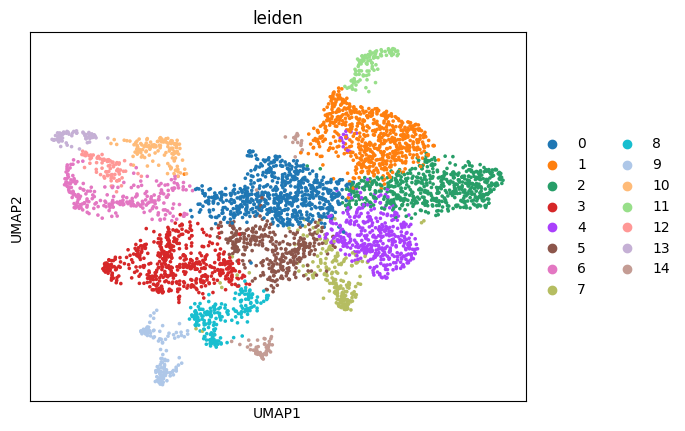

In [68]:
sc.pl.umap(combined, color="omics")
sc.pl.umap(combined, color="leiden")
# sc.pl.umap(combined, color="paired")
# sc.pl.umap(combined, color = "RNA_clusters")

In [69]:
t_rna = combined[combined.obs["omics"]=="0",]
t_atac = combined[combined.obs["omics"]=="1",]

In [70]:
# order = []
# color_map = {}
# fig = plt.figure(constrained_layout=True, figsize=(15,15))
# grid = plt.GridSpec(1, 1 , right=0.99,left=0.01)
# ax1 = fig.add_subplot(grid[0,0:1])
# # ax1.set(facecolor = "black")
# sc.pl.spatial(adata, color="cluster_annot_correct", spot_size=25, title="",palette=color_map, ax=ax1, show=False, frameon=False)
# ax1.legend(ncol=1, frameon=False)
# handles, labels = plt.gca().get_legend_handles_labels()

# #specify order of items in legend

# #add legend to plot
# ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncol=1, bbox_to_anchor=(1.2,1.0),
#            prop = {'size':15, },borderaxespad = 0, columnspacing=0, labelspacing=0.4, handletextpad=0, frameon=False, markerscale=1.5)
# plt.show()

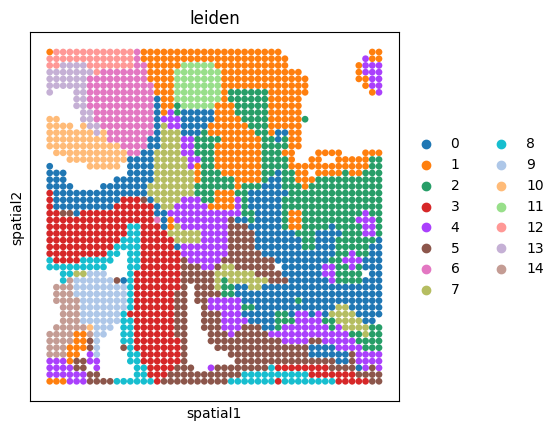

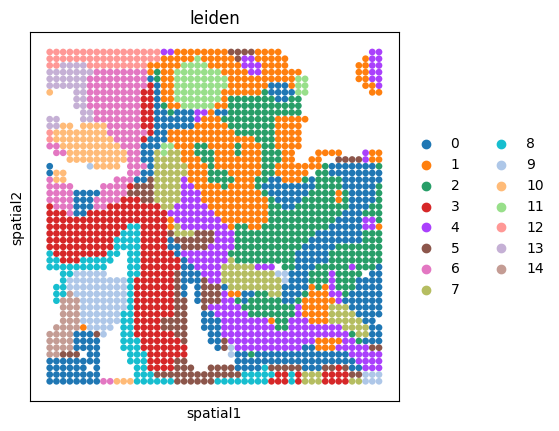

In [71]:
sc.pl.spatial(t_rna, color="leiden",spot_size=1)
sc.pl.spatial(t_atac, color="leiden",spot_size=1)
# sc.pl.spatial(atac, color="paired",spot_size=1)
# sc.pl.spatial(t_atac, color="RNA_clusters",spot_size=1)

In [72]:
rna.obsm["X_umap"] = t_rna.obsm["X_umap"]

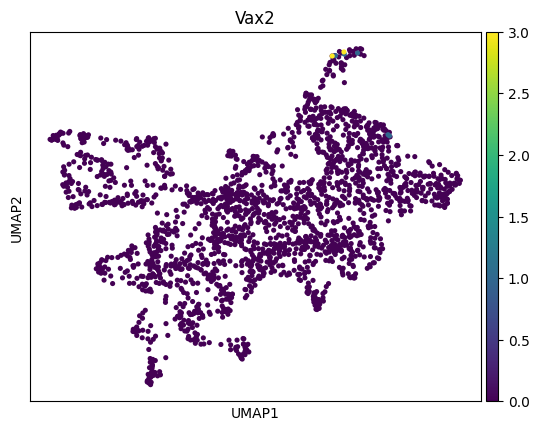

In [73]:
sc.pl.umap(rna, color="Vax2")

In [74]:
import scipy
def foscttm(
        x: np.ndarray, y: np.ndarray, **kwargs
):
    if x.shape != y.shape:
        raise ValueError("Shapes do not match!")
    d = scipy.spatial.distance_matrix(x, y, **kwargs)
    n1, _ = d.shape
    true_matching = np.arange(n1)
    # mask[i, j] = True iff dist[i, j] < dist[i, true_matching[i]]
    mask = (d.T < d[np.arange(n1), true_matching]).T
    return np.mean(np.mean(mask, axis=1))

In [75]:
x=foscttm(t_rna.obsm["SWITCH"], t_atac.obsm["SWITCH"])
x

0.123863023155701

In [76]:
# model.save("model.pth", overwrite=True)

In [77]:
# import pandas as pd
# cluster = combined.obs['leiden']
# cluster.to_csv("rep1/SWITCH_cluster.csv")
# umap = pd.DataFrame(combined.obsm["X_umap"])
# umap.to_csv("rep1/SWITCH_umap.csv")
# embed = pd.DataFrame(combined.obsm["SWITCH"])
# embed.to_csv("rep1/SWITCH_embed.csv")

In [78]:
imputed_rna =  model.impute_data(source_key="atac",target_key="rna", source_adata=atac, target_adata=rna,graph=guidance_hvf)
imputed_rna = ad.AnnData(X=np.array(imputed_rna))

In [79]:
imputed_rna.var["highly_variable"] = True
imputed_rna.obsm["spatial"] = rna.obsm["spatial"]
imputed_rna.var_names = list(rna[:,rna.var["highly_variable"]].var_names)

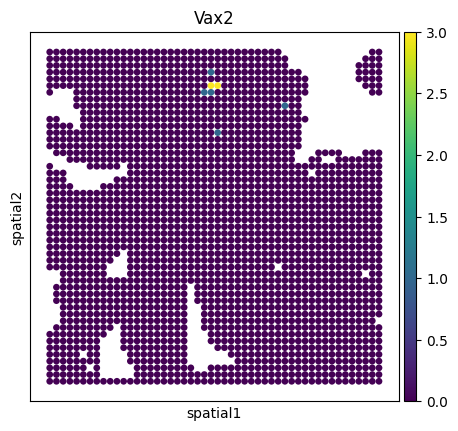

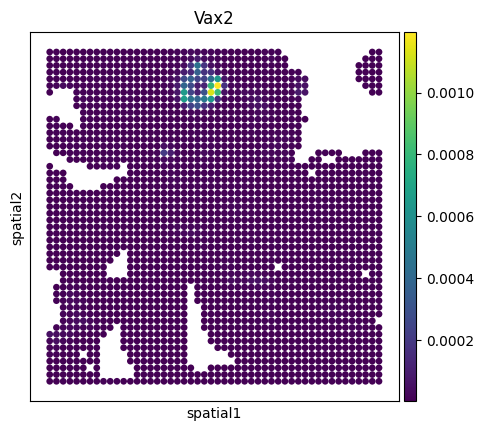

In [80]:
sc.pl.spatial(rna, color="Vax2", spot_size=1)
sc.pl.spatial(imputed_rna, color="Vax2", spot_size=1)

In [81]:
# imputed_atac =  model.impute_data(source_key="rna",target_key="atac",source_adata=rna, target_adata=atac, graph=guidance_hvf,target_libsize=1e4)
# imputed_atac = ad.AnnData(X=np.array(imputed_atac))
# imputed_atac.var["highly_variable"] = True
# imputed_atac.obsm["spatial"] = atac.obsm["spatial"]
# imputed_atac.var_names = list(atac[:,atac.var["highly_variable"]].var_names)
# imputed_rna.write("imputed_rna.h5ad")
# imputed_atac.write("imputed_atac.h5ad")